In [1]:
!pip install keras==2.2.0

    100% |████████████████████████████████| 307kB 19.7MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 28.3MB/s ta 0:00:01
tensorflow 1.13.1 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.2 which is incompatible.
tensorflow 1.13.1 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.1 which is incompatible.
  Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
  Found existing installation: Keras-Preprocessing 1.0.9
    Uninstalling Keras-Preprocessing-1.0.9:
      Successfully uninstalled Keras-Preprocessing-1.0.9
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
from __future__ import print_function, division

from keras.applications.vgg19 import VGG19
from keras.layers import Input, Dense, Flatten, Dropout, Reshape
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
from keras import models
from keras import layers
from keras import optimizers

from keras.datasets import cifar10
import keras.backend as K
import tensorflow as tf
from tensorflow.python.keras import backend as K
from keras.models import load_model

import matplotlib.pyplot as plt

import sys
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install keras_vggface

    100% |████████████████████████████████| 51kB 11.2MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 26.2MB/s ta 0:00:01
  Stored in directory: /tmp/.cache/pip/wheels/72/aa/01/eb7baeb2f6e2d2f0d2aabddb5f01d57fa22fbd019ee2799bf5
Successfully built keras-vggface
keras 2.2.0 has requirement keras-applications==1.0.2, but you'll have keras-applications 1.0.8 which is incompatible.
keras 2.2.0 has requirement keras-preprocessing==1.0.1, but you'll have keras-preprocessing 1.1.0 which is incompatible.
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
from keras_applications.imagenet_utils import _obtain_input_shape 


In [6]:
from keras_vggface import VGGFace

In [7]:
  vgg_model = VGGFace(include_top=False, input_shape=(64, 64, 3))
  vgg_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
58916864/58909280 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 128)       147584    
_____

In [8]:
  #vgg_model = VGG19(weights = "imagenet",include_top=False, input_shape=(64, 64, 3))

  #t=15
  #while t>0:
    #vgg_model.layers.pop()
    #t=t-1
  #vgg_model.summary()

In [41]:
def get_generator(input_layer):
 
  hid = Dense(128 * 32 * 32, activation='relu')(input_layer)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((32, 32, 128))(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  #hid = Dropout(0.5)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(input_layer, out)
  model.summary()
  
  return model, out

In [42]:
def get_discriminator(input_layer):
  '''
  Requires the input layer as input, outputs the model and the final layer
  '''
  vgg_model = VGGFace(include_top=False, input_shape=(128, 128, 3))
  nb_class = 1
  hidden_dim = 512
  for layer in vgg_model.layers[:9]:
    layer.trainable=False
  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)
  x = Dense(hidden_dim,name='fc6')(x)
  x = LeakyReLU(alpha=0.1)(x)
  #x = Dense(128,name='fc7')(x)
  #x = LeakyReLU(alpha=0.1)(x)
  out = Dense(nb_class, activation='sigmoid', name='fc8')(x)  

  model = Model(vgg_model.input, out)

  model.summary()

  return model, out

In [43]:
from keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def show_imgs(batchidx):
  noise = generate_noise(9, 100)
  gen_imgs = generator.predict(noise)

  fig, axs = plt.subplots(3, 3)
  count = 0
  for i in range(3):
    for j in range(3):
      img = image.array_to_img(gen_imgs[count], scale=True)
      axs[i,j].imshow(img)
      axs[i,j].axis('off')
      count += 1
  plt.show()
  plt.close()

In [44]:
# GAN creation
img_input = Input(shape=(128,128,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(100,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 64, 64, 128)       147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 128)       0         
__________

In [13]:
import os

In [14]:
# Data
BASE_PATH = "../input/celebrities-100k/"
print(os.listdir(BASE_PATH))
#BASE_PATH = base_PATH+ 'celebrities-100k' 
DATASET_LIST_PATH= BASE_PATH + "100k.txt"
print(DATASET_LIST_PATH)



['100k', '100k.txt']
../input/celebrities-100k/100k.txt


In [15]:
DATASET_LIST_PATH


'../input/celebrities-100k/100k.txt'

In [16]:
INPUT_DATA_DIR = BASE_PATH + "100k/100k/"


In [17]:
INPUT_DATA_DIR

'../input/celebrities-100k/100k/100k/'

In [18]:
OUTPUT_DIR = "./"


In [19]:
#MODEL_PATH = BASE_PATH + "models/" + "model_" + str(EPOCH) + ".ckpt"
DATASET = [INPUT_DATA_DIR + str(line).rstrip() for line in open(DATASET_LIST_PATH,"r")]

In [20]:
len(DATASET)

100000

In [21]:
data=DATASET[:10000]

In [22]:
#model_path = '../input/facenet-keras/facenet_keras.h5'
#facenet = load_model(model_path)

In [23]:
#facenet.summary()

In [24]:
import scipy.misc
import scipy.ndimage

In [26]:
#uploading images from folder
images = []
for img_name in data:
    image = scipy.ndimage.imread(img_name, mode="RGB")
    image_resized = scipy.misc.imresize(image,(128,128))
    images.append(image_resized)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [27]:
train_x = np.stack(images)

In [28]:
train_x.shape

(10000, 128, 128, 3)

In [29]:
X_train = train_x

In [30]:
X_train = ((X_train)-127.5)/127.5

In [31]:
BATCH_SIZE = 64

# # Get training images
#(X_train, y_train), (X_test, _) = cifar10.load_data()

# S

# Normalize data
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

In [32]:
X_train.shape

(10000, 128, 128, 3)

In [33]:
import time

In [34]:
disc=[]

/opt/conda/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


  Epoch: 1, Generator Loss: 1.599849359729351, Discriminator Loss: [0.59031415 0.        ]


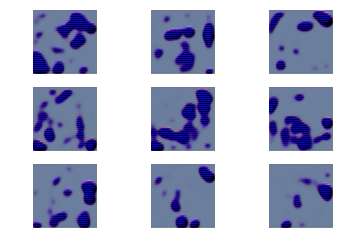

For epoch: 1, Time taken is: 133.35626649856567 seconds
  Epoch: 2, Generator Loss: 1.7390759182281983, Discriminator Loss: [0.4422446 0.       ]


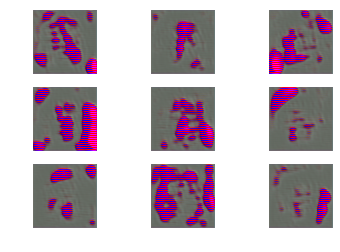

For epoch: 2, Time taken is: 125.52752327919006 seconds
  Epoch: 3, Generator Loss: 1.9920407466781445, Discriminator Loss: [0.36304307 0.        ]


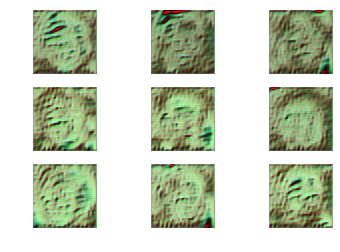

For epoch: 3, Time taken is: 125.5165491104126 seconds
  Epoch: 4, Generator Loss: 2.2805724235681386, Discriminator Loss: [0.34947255 0.        ]


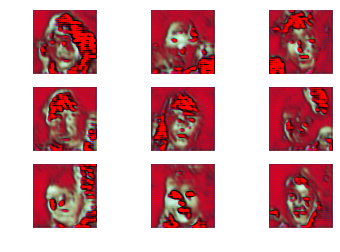

For epoch: 4, Time taken is: 125.514892578125 seconds
  Epoch: 5, Generator Loss: 2.249945968389511, Discriminator Loss: [0.33999255 0.        ]


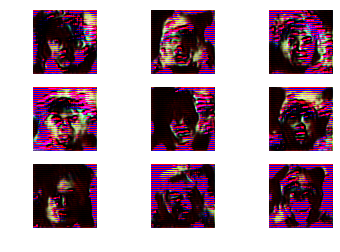

For epoch: 5, Time taken is: 125.5202214717865 seconds
  Epoch: 6, Generator Loss: 2.388556958009035, Discriminator Loss: [0.33650452 0.        ]


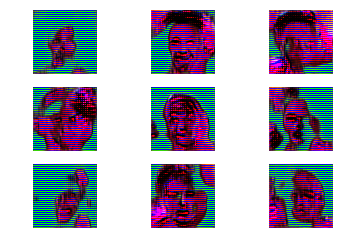

For epoch: 6, Time taken is: 125.46094107627869 seconds
  Epoch: 7, Generator Loss: 2.2399411851014848, Discriminator Loss: [0.35879624 0.        ]


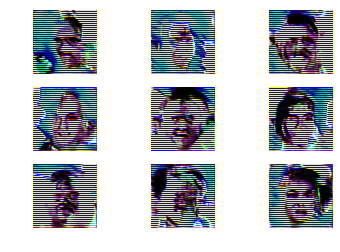

For epoch: 7, Time taken is: 125.45491862297058 seconds
  Epoch: 8, Generator Loss: 2.279707971291664, Discriminator Loss: [0.3274195 0.       ]


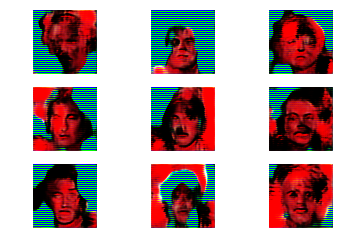

For epoch: 8, Time taken is: 125.4823009967804 seconds
  Epoch: 9, Generator Loss: 2.3651765004182472, Discriminator Loss: [0.36270037 0.        ]


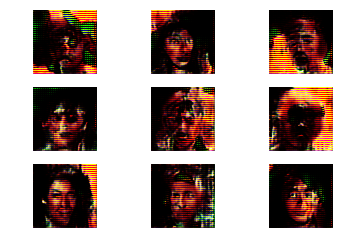

For epoch: 9, Time taken is: 125.4568727016449 seconds
  Epoch: 10, Generator Loss: 2.3488324827108626, Discriminator Loss: [0.35130367 0.        ]


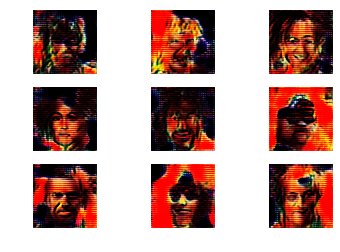

For epoch: 10, Time taken is: 125.4481828212738 seconds
  Epoch: 11, Generator Loss: 2.3635308024210806, Discriminator Loss: [0.35126898 0.        ]


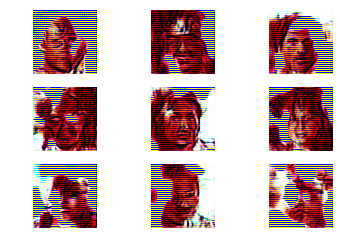

For epoch: 11, Time taken is: 125.4357681274414 seconds
  Epoch: 12, Generator Loss: 2.340210877932035, Discriminator Loss: [0.35854974 0.        ]


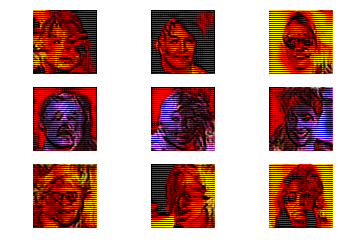

For epoch: 12, Time taken is: 125.21234583854675 seconds
  Epoch: 13, Generator Loss: 2.3086667228967714, Discriminator Loss: [0.3609246 0.       ]


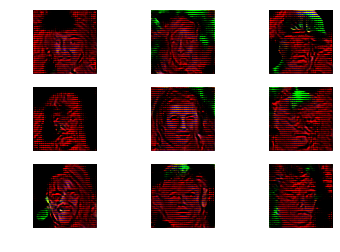

For epoch: 13, Time taken is: 125.56919479370117 seconds
  Epoch: 14, Generator Loss: 2.3317506909370422, Discriminator Loss: [0.37051508 0.        ]


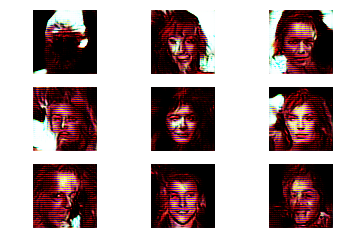

For epoch: 14, Time taken is: 125.86699914932251 seconds
  Epoch: 15, Generator Loss: 2.3192229515466933, Discriminator Loss: [0.36179823 0.        ]


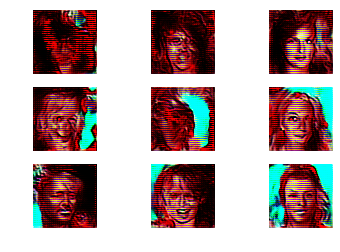

For epoch: 15, Time taken is: 125.80642557144165 seconds
  Epoch: 16, Generator Loss: 2.3030088681441088, Discriminator Loss: [0.36032942 0.        ]


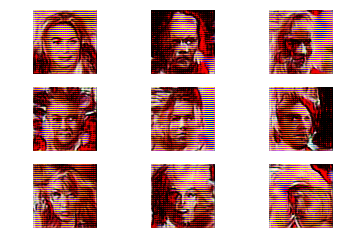

For epoch: 16, Time taken is: 125.79119944572449 seconds
  Epoch: 17, Generator Loss: 2.305962851414314, Discriminator Loss: [0.35428843 0.        ]


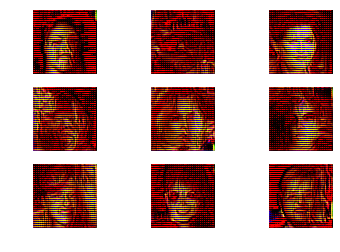

For epoch: 17, Time taken is: 125.70555543899536 seconds
  Epoch: 18, Generator Loss: 2.2609672393554296, Discriminator Loss: [0.34845927 0.        ]


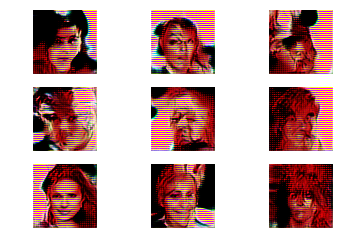

For epoch: 18, Time taken is: 125.29012608528137 seconds
  Epoch: 19, Generator Loss: 2.302421893064792, Discriminator Loss: [0.3583383 0.       ]


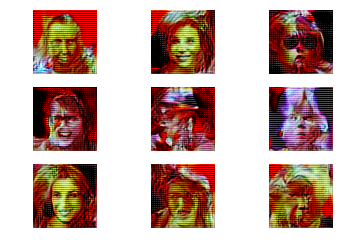

For epoch: 19, Time taken is: 125.26032638549805 seconds
  Epoch: 20, Generator Loss: 2.2246775443737326, Discriminator Loss: [0.349642 0.      ]


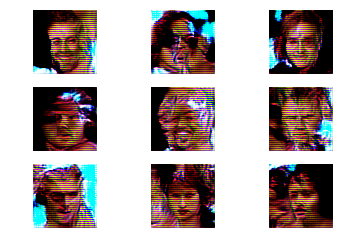

For epoch: 20, Time taken is: 125.27638053894043 seconds
  Epoch: 21, Generator Loss: 2.3039855047678337, Discriminator Loss: [0.36248812 0.        ]


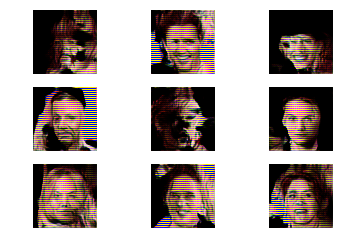

For epoch: 21, Time taken is: 125.22729444503784 seconds
  Epoch: 22, Generator Loss: 2.3245360453923545, Discriminator Loss: [0.3542706 0.       ]


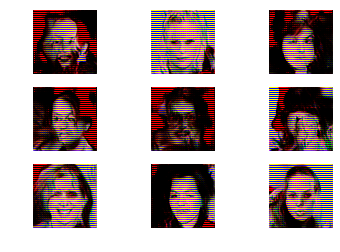

For epoch: 22, Time taken is: 125.21794486045837 seconds
  Epoch: 23, Generator Loss: 2.287104212320768, Discriminator Loss: [0.32232127 0.        ]


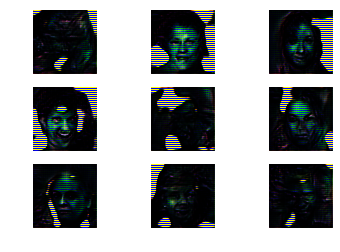

For epoch: 23, Time taken is: 125.22947072982788 seconds
  Epoch: 24, Generator Loss: 2.3385114539892244, Discriminator Loss: [0.336346 0.      ]


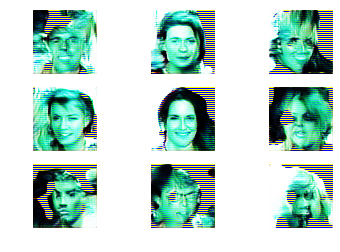

For epoch: 24, Time taken is: 125.21563029289246 seconds
  Epoch: 25, Generator Loss: 2.3315875820624523, Discriminator Loss: [0.34702662 0.        ]


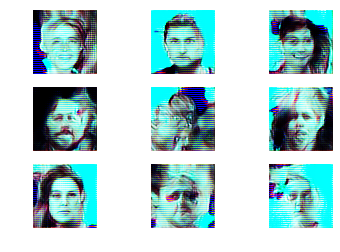

For epoch: 25, Time taken is: 124.99517607688904 seconds
  Epoch: 26, Generator Loss: 2.3141669653929196, Discriminator Loss: [0.3458649 0.       ]


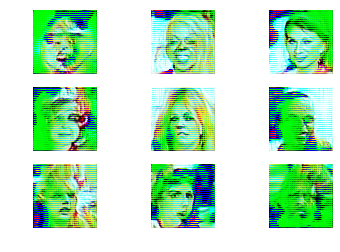

For epoch: 26, Time taken is: 124.98854064941406 seconds
  Epoch: 27, Generator Loss: 2.285377879173328, Discriminator Loss: [0.34414926 0.        ]


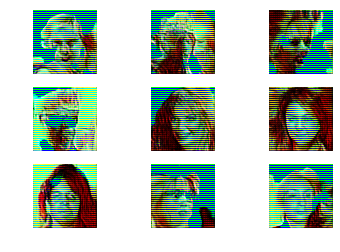

For epoch: 27, Time taken is: 124.98622250556946 seconds
  Epoch: 28, Generator Loss: 2.3080053566358028, Discriminator Loss: [0.34093058 0.        ]


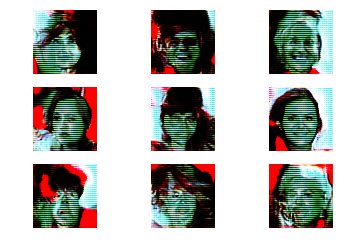

For epoch: 28, Time taken is: 125.04480147361755 seconds
  Epoch: 29, Generator Loss: 2.332590026733203, Discriminator Loss: [0.3476277 0.       ]


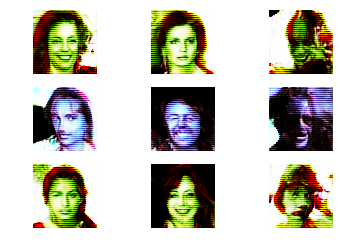

For epoch: 29, Time taken is: 124.98853278160095 seconds
  Epoch: 30, Generator Loss: 2.2988075560484176, Discriminator Loss: [3.389820e-01 5.008013e-05]


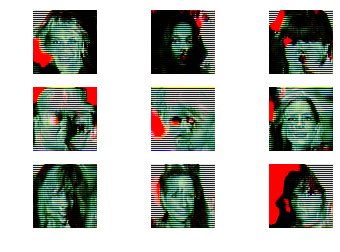

For epoch: 30, Time taken is: 125.12158465385437 seconds
  Epoch: 31, Generator Loss: 2.3017083001442447, Discriminator Loss: [0.34501928 0.        ]


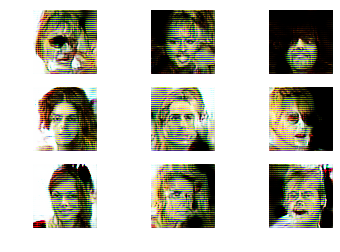

For epoch: 31, Time taken is: 125.06982231140137 seconds
  Epoch: 32, Generator Loss: 2.27561491727829, Discriminator Loss: [0.3484427 0.       ]


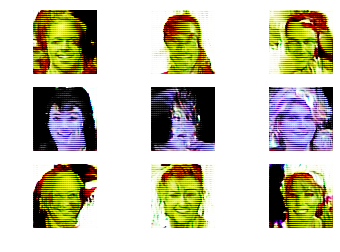

For epoch: 32, Time taken is: 125.15343379974365 seconds
  Epoch: 33, Generator Loss: 2.3002243446998105, Discriminator Loss: [0.3436352 0.       ]


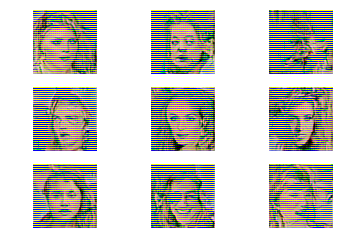

For epoch: 33, Time taken is: 124.9499568939209 seconds
  Epoch: 34, Generator Loss: 2.343357253533143, Discriminator Loss: [0.32187375 0.        ]


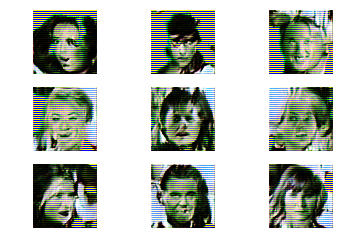

For epoch: 34, Time taken is: 125.3639121055603 seconds
  Epoch: 35, Generator Loss: 2.3253777821858725, Discriminator Loss: [0.33669278 0.        ]


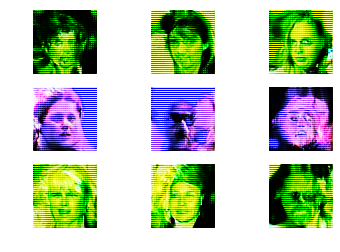

For epoch: 35, Time taken is: 125.15750169754028 seconds
  Epoch: 36, Generator Loss: 2.322003265221914, Discriminator Loss: [0.33841658 0.        ]


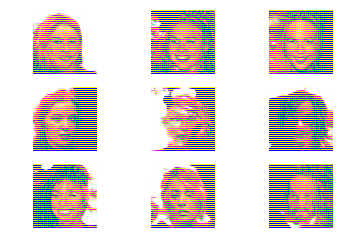

For epoch: 36, Time taken is: 125.15783858299255 seconds
  Epoch: 37, Generator Loss: 2.3262025775053563, Discriminator Loss: [0.3404125 0.       ]


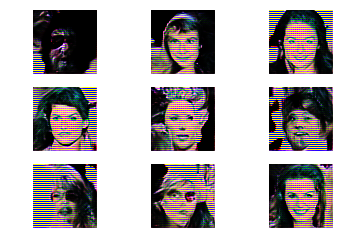

For epoch: 37, Time taken is: 125.23779940605164 seconds
  Epoch: 38, Generator Loss: 2.292288620502521, Discriminator Loss: [0.33944494 0.        ]


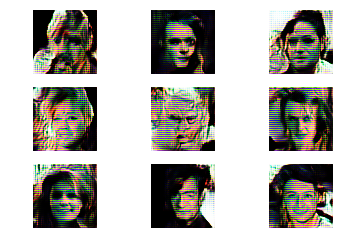

For epoch: 38, Time taken is: 125.39153718948364 seconds
  Epoch: 39, Generator Loss: 2.3104296242579436, Discriminator Loss: [0.3459395 0.       ]


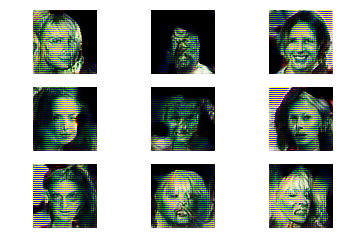

For epoch: 39, Time taken is: 125.44434976577759 seconds
  Epoch: 40, Generator Loss: 2.323470401458251, Discriminator Loss: [0.33990732 0.        ]


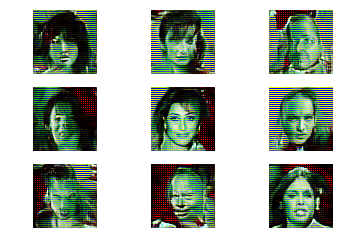

For epoch: 40, Time taken is: 125.60270237922668 seconds
  Epoch: 41, Generator Loss: 2.304996746472823, Discriminator Loss: [0.3386531 0.       ]


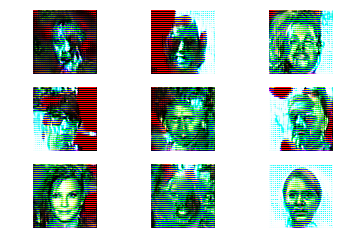

For epoch: 41, Time taken is: 125.64980506896973 seconds
  Epoch: 42, Generator Loss: 2.32718174579816, Discriminator Loss: [0.33790013 0.        ]


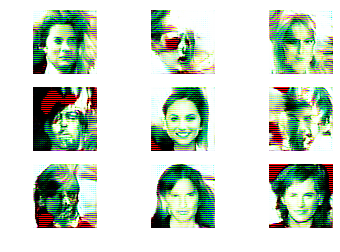

For epoch: 42, Time taken is: 125.68207430839539 seconds
  Epoch: 43, Generator Loss: 2.334179232517878, Discriminator Loss: [0.3376511 0.       ]


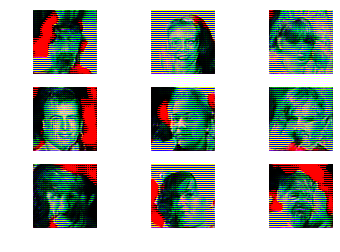

For epoch: 43, Time taken is: 125.66786766052246 seconds
  Epoch: 44, Generator Loss: 2.337351490289737, Discriminator Loss: [0.3289321 0.       ]


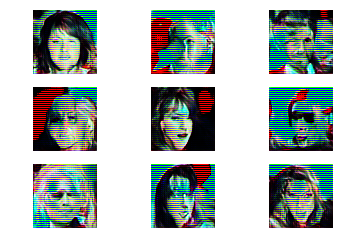

For epoch: 44, Time taken is: 125.69398427009583 seconds
  Epoch: 45, Generator Loss: 2.316148905417858, Discriminator Loss: [0.33028552 0.        ]


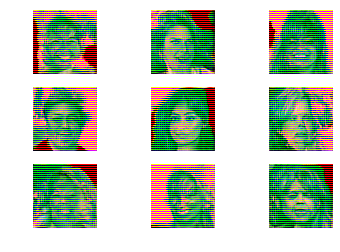

For epoch: 45, Time taken is: 125.75381445884705 seconds
  Epoch: 46, Generator Loss: 2.341420265344473, Discriminator Loss: [0.34007666 0.        ]


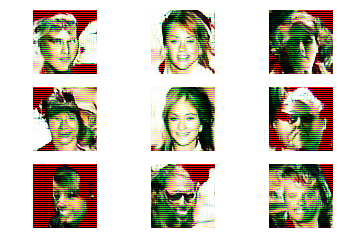

For epoch: 46, Time taken is: 125.75764346122742 seconds
  Epoch: 47, Generator Loss: 2.324959014470761, Discriminator Loss: [0.3352418 0.       ]


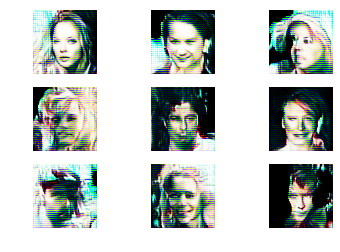

For epoch: 47, Time taken is: 125.74099540710449 seconds
  Epoch: 48, Generator Loss: 2.312122031664237, Discriminator Loss: [0.3374713 0.       ]


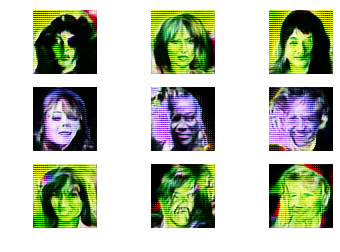

For epoch: 48, Time taken is: 125.68817138671875 seconds
  Epoch: 49, Generator Loss: 2.2974199056625366, Discriminator Loss: [0.34082943 0.        ]


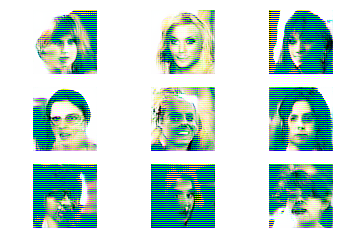

For epoch: 49, Time taken is: 125.65442180633545 seconds
  Epoch: 50, Generator Loss: 2.3197802786643686, Discriminator Loss: [0.33753905 0.        ]


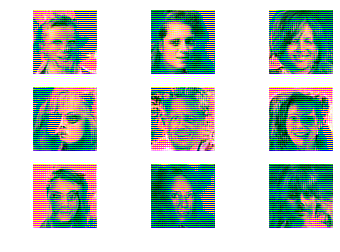

For epoch: 50, Time taken is: 125.67606139183044 seconds
  Epoch: 51, Generator Loss: 2.360285129302587, Discriminator Loss: [0.3288109 0.       ]


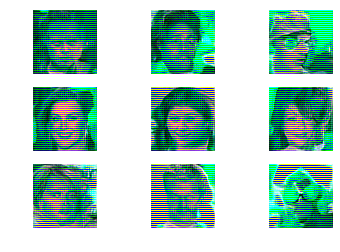

For epoch: 51, Time taken is: 125.64015555381775 seconds
  Epoch: 52, Generator Loss: 2.357921987007826, Discriminator Loss: [0.33320758 0.        ]


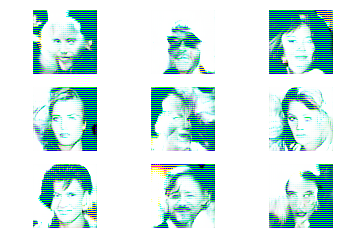

For epoch: 52, Time taken is: 125.67212414741516 seconds
  Epoch: 53, Generator Loss: 2.3255265668416634, Discriminator Loss: [0.3362042 0.       ]


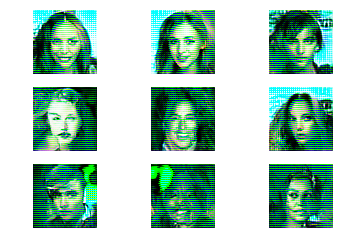

For epoch: 53, Time taken is: 125.60548257827759 seconds
  Epoch: 54, Generator Loss: 2.3037008115878472, Discriminator Loss: [0.34709764 0.        ]


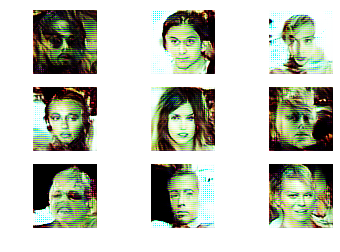

For epoch: 54, Time taken is: 126.00223350524902 seconds
  Epoch: 55, Generator Loss: 2.3034291725892286, Discriminator Loss: [0.33809546 0.        ]


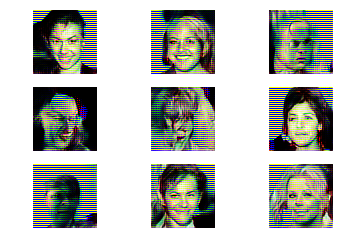

For epoch: 55, Time taken is: 125.55633330345154 seconds


In [45]:
N_EPOCHS = 55
CUMM_DLOSS=0
for epoch in range(N_EPOCHS):
  tic=time.time()
  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Get the next set of real images to be used in this iteration
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    generated_images = generator.predict(noise_data)

    # Train on soft labels (add noise to labels as well)
    noise_prop = 0.05 # Randomly flip 5% of labels
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch(images, true_labels)

    # Prepare labels for generated data
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)

    d_loss = 0.5*np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss
    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss

#   #for whole data:-
#   IMAGES=X_train 
#   Noise_Data = generate_noise(10000, 100)
#   Generated_Images = generator.predict(Noise_Data)
#   # Prepare labels for real data
#   True_Labels = np.zeros((10000, 1)) + np.random.uniform(low=0.0, high=0.1, size=(10000, 1))
#   Flipped_Idx = np.random.choice(np.arange(len(True_Labels)), size=int(noise_prop*len(True_Labels)))
#   True_Labels[Flipped_Idx] = 1 - True_Labels[Flipped_Idx]
  
#   # EVALUATE discriminator on real data
#   DLOSS_TRUE = discriminator.evaluate(IMAGES, True_Labels) 

#   # Prepare labels for generated data
#   Gene_Labels = np.ones((10000, 1)) - np.random.uniform(low=0.0, high=0.1, size=(10000, 1))
#   Flipped_Idx = np.random.choice(np.arange(len(Gene_Labels)), size=int(noise_prop*len(Gene_Labels)))
#   Gene_Labels[Flipped_Idx] = 1 - Gene_Labels[Flipped_Idx]
    
  
  
#   # EVALUTE discriminator on generated data
#   D_LOSS_GENE = discriminator.evaluate(Generated_Images, Gene_Labels) 
#   D_LOSS=0.5*np.add(DLOSS_TRUE,D_LOSS_GENE)
#   CUMM_DLOSS+=D_LOSS
   
#   print("  Epoch:- "+str(epoch+1)+", D LOSS: "+str(D_LOSS) + "; Cummulative D_LOSS: "+ str(CUMM_DLOSS) )
    
  
#   noise_data = generate_noise(BATCH_SIZE, 100)
  #generated_images = generator.predict(noise_data)
  disc.append(cum_d_loss/num_batches)
  print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
  show_imgs("epoch" + str(epoch))
  toc=time.time()
  print("For epoch: "+ str(epoch +1)+", Time taken is: " +str(toc-tic)+ " seconds")
  #print(discriminator.predict(generated_images))


In [46]:
x_axis=np.stack(disc)

In [52]:
x_axis=x_axis[15:]

In [59]:
Y_axis=x_axis[:,0]

In [64]:
Y_axis

array([0.59031415, 0.4422446 , 0.36304307, 0.34947255, 0.33999255,
       0.33650452, 0.35879624, 0.3274195 , 0.36270037, 0.35130367,
       0.35126898, 0.35854974, 0.3609246 , 0.37051508, 0.36179823,
       0.36032942, 0.35428843, 0.34845927, 0.3583383 , 0.349642  ,
       0.36248812, 0.3542706 , 0.32232127, 0.336346  , 0.34702662,
       0.3458649 , 0.34414926, 0.34093058, 0.3476277 , 0.338982  ,
       0.34501928, 0.3484427 , 0.3436352 , 0.32187375, 0.33669278,
       0.33841658, 0.3404125 , 0.33944494, 0.3459395 , 0.33990732,
       0.3386531 , 0.33790013, 0.3376511 , 0.3289321 , 0.33028552,
       0.34007666, 0.3352418 , 0.3374713 , 0.34082943, 0.33753905,
       0.3288109 , 0.33320758, 0.3362042 , 0.34709764, 0.33809546],
      dtype=float32)

In [61]:
X_axis=np.arange(55)

In [65]:
for i in range(55):
    X_axis[i]=X_axis[i]+1

In [66]:
X_axis

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55])

In [67]:
import matplotlib.pyplot as plt 


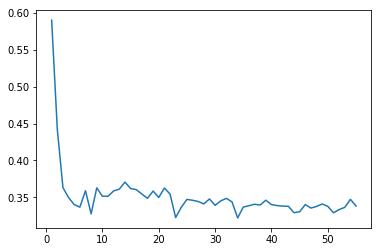

In [68]:
plt.plot(X_axis,Y_axis)